<a href="https://colab.research.google.com/github/psychpraphool/6CS012-AI-and-ML-WeeklyWorkshop/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Detection in Credit Card Transactions**

Environment Setup

In [4]:
# 1) Install / upgrade required packages
!pip install --upgrade xgboost imbalanced-learn matplotlib seaborn

# 2) (Optional) Mount Google Drive if your data/code live there
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
Mounted at /content/drive


Import Necessary Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
)
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# For reproducibility
RANDOM_STATE = 42


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f64960134c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-24e2ab19.so.1.0.0

# **Part 1: Data Loading and Preprocessing**

Load & Inspect Data

In [6]:
# Adjust path if mounted in Drive
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
df.head(), df.info(), df['Class'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

Define features and target

In [7]:
X = df.drop(columns=['Class'])
y = df['Class']

Scale the Amount feature

In [8]:
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])


Split into train/test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Test set  class distribution:\n", y_test.value_counts(normalize=True))

Training set class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test set  class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Apply SMOTE to the training data to balance the classes

In [10]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE, training distribution:\n", y_train_res.value_counts(normalize=True))

After SMOTE, training distribution:
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64


# **Part 2: Exploratory Data Analysis**

Descriptive statistics and class distribution

In [11]:
print(df.describe())
print("\nClass distribution:\n", df['Class'].value_counts())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

Transaction Amount distribution by class

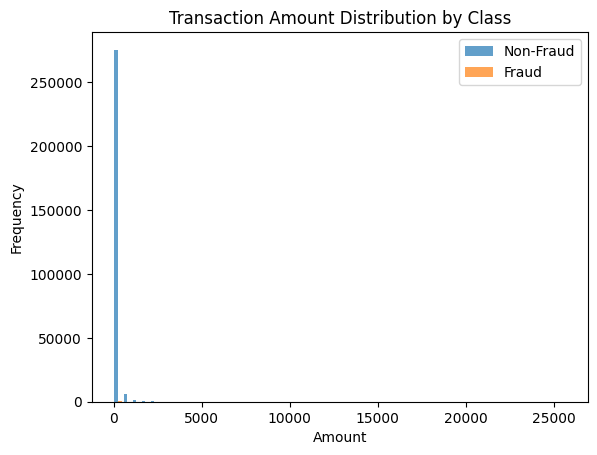

In [12]:
plt.figure()
plt.hist([df[df['Class']==0]['Amount'],
          df[df['Class']==1]['Amount']],
         bins=50,
         label=['Non-Fraud','Fraud'],
         alpha=0.7)
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Boxplot of Amount by class

<ipython-input-13-6a4b1facc12f>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['Class']==0]['Amount'],


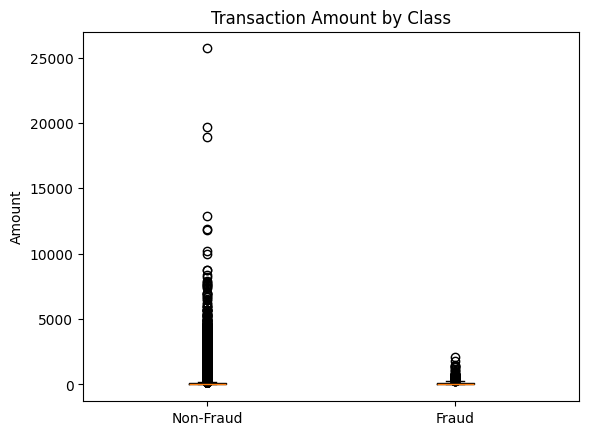

In [13]:
plt.figure()
plt.boxplot([df[df['Class']==0]['Amount'],
             df[df['Class']==1]['Amount']],
            labels=['Non-Fraud','Fraud'])
plt.title('Transaction Amount by Class')
plt.ylabel('Amount')
plt.show()

Top correlations with the target

In [14]:
corr_with_target = df.corr()['Class'].abs().sort_values(ascending=False)
print("Top 10 features by |corr| with Class:\n", corr_with_target.head(10))

Top 10 features by |corr| with Class:
 Class    1.000000
V17      0.326481
V14      0.302544
V12      0.260593
V10      0.216883
V16      0.196539
V3       0.192961
V7       0.187257
V11      0.154876
V4       0.133447
Name: Class, dtype: float64


Full correlation matrix heatmap

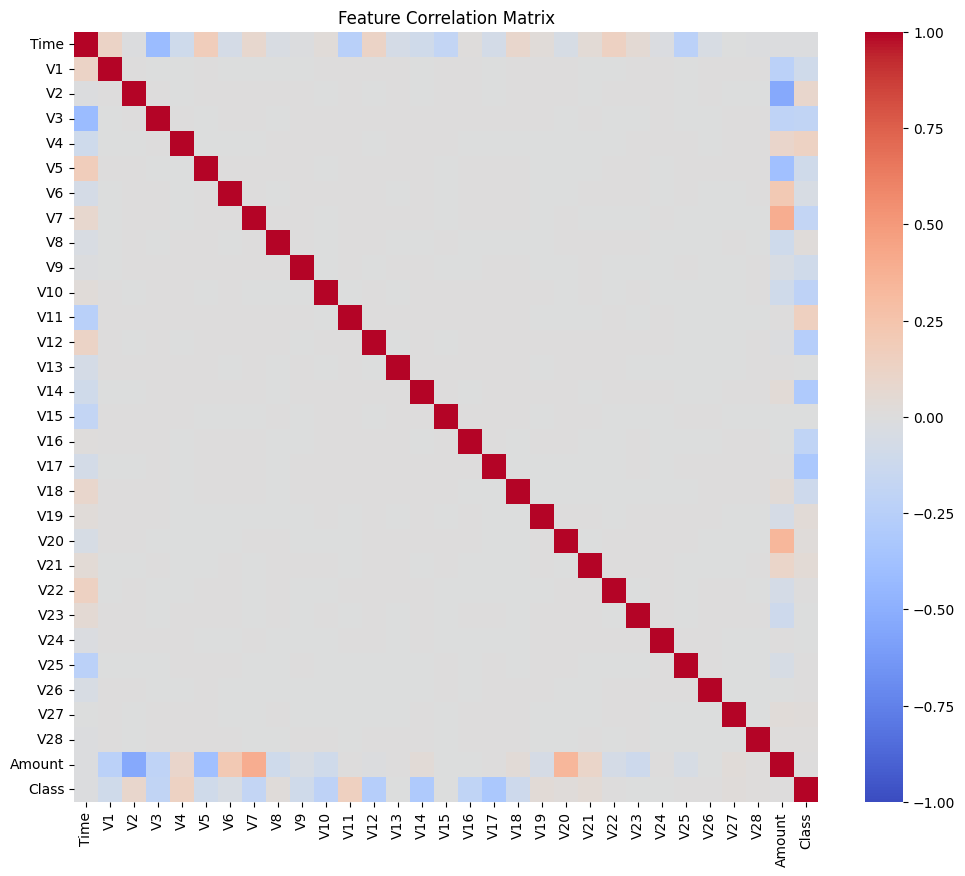

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# **Part 3: Feature Selection**

Univariate feature selection (ANOVA F-test) on SMOTE-balanced data

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train_res, y_train_res)
top_features_anova = X_train_res.columns[selector.get_support()]
print("Top 10 features by ANOVA F-test:\n", list(top_features_anova))

Top 10 features by ANOVA F-test:
 ['V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


Model-based feature importance via Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
importances = pd.Series(rf.feature_importances_, index=X_train_res.columns)
print("Top 10 features by RF importance:\n", importances.sort_values(ascending=False).head(10))

Top 10 features by RF importance:
 V14    0.209431
V10    0.127031
V4     0.114768
V12    0.102589
V17    0.086890
V3     0.074048
V11    0.051433
V16    0.043196
V2     0.037046
V9     0.027998
dtype: float64


# **Part: 4 Model Development and Evaluation**

Train & evaluate XGBoost

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, classification_report
)

xgb = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train_res, y_train_res)

y_pred_xgb  = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("=== XGBoost Performance ===")
print(classification_report(y_test, y_pred_xgb, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"MCC:     {matthews_corrcoef(y_test, y_pred_xgb):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "


=== XGBoost Performance ===
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.7727    0.8673    0.8173        98

    accuracy                         0.9993     56962
   macro avg     0.8862    0.9335    0.9085     56962
weighted avg     0.9994    0.9993    0.9994     56962

ROC-AUC: 0.9789
MCC:     0.8183


Train & evaluate Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("=== Random Forest Performance ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"MCC:     {matthews_corrcoef(y_test, y_pred_rf):.4f}")

=== Random Forest Performance ===
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8265    0.8265    0.8265        98

    accuracy                         0.9994     56962
   macro avg     0.9131    0.9131    0.9131     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9692
MCC:     0.8262


Train & evaluate Multi-Layer Perceptron

In [21]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=100
)
mlp.fit(X_train_res, y_train_res)

y_pred_mlp  = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:,1]

print("=== MLP Performance ===")
print(classification_report(y_test, y_pred_mlp, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_mlp):.4f}")
print(f"MCC:     {matthews_corrcoef(y_test, y_pred_mlp):.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


=== MLP Performance ===
              precision    recall  f1-score   support

           0     0.9998    0.9772    0.9883     56864
           1     0.0628    0.8878    0.1173        98

    accuracy                         0.9770     56962
   macro avg     0.5313    0.9325    0.5528     56962
weighted avg     0.9982    0.9770    0.9869     56962

ROC-AUC: 0.9606
MCC:     0.2326


Plot ROC curves for all three models

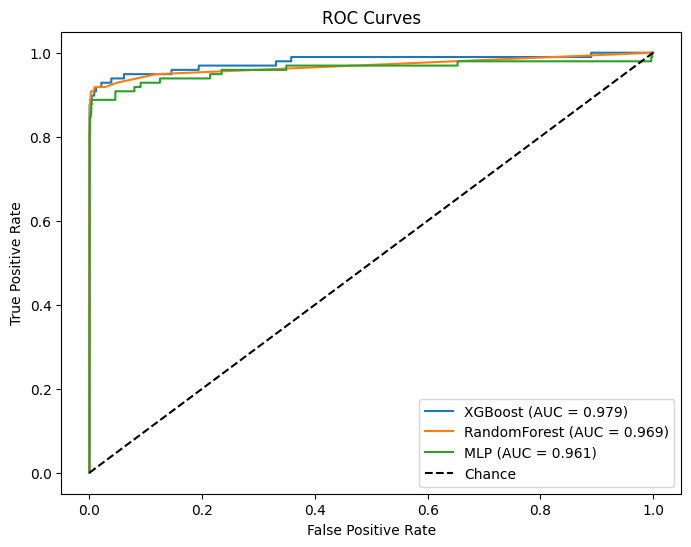

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))

models = [
    ('XGBoost', y_proba_xgb),
    ('RandomForest', y_proba_rf),
    ('MLP', y_proba_mlp)
]

for name, probs in models:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()